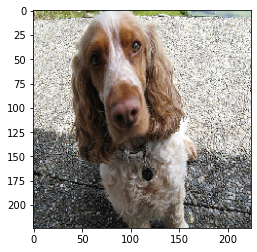

In [1]:
# test image from imagenet
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
orig_img = image.load_img('data/dog.jpg',target_size=(224,224))
orig_img = np.asarray(orig_img)
plt.imshow(orig_img)
img = np.expand_dims(orig_img, axis=0)

In [2]:
from model import load_model
import cv2

In [3]:
test=load_model('VGG16')

In [4]:
index=test.class_index(img)

In [5]:
model=test.model
layer_name='block5_conv3'

In [6]:
from explanation_models import gradcam

In [7]:
g= gradcam(model,layer_name)
heatmap=g.get_heatmap(img,index)
heatmap_colormap,overlayed_img=g.overlay_heatmap(orig_img,heatmap)

&lt;matplotlib.image.AxesImage at 0x7f1b8dd9d940&gt;

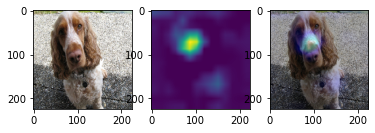

In [10]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap)
axarr[2].imshow(overlayed_img)